In [2]:
pip install torch


     -------------------------------------- 212.4/212.4 MB 2.6 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 3.0 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.10.1
    Uninstalling sympy-1.10.1:
      Successfully uninstalled sympy-1.10.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torchvision


     ---------------------------------------- 1.7/1.7 MB 215.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# data
root = "data"

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64
# percentage of training set to use as validation
valid_size = 0.2

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dataset = datasets.mnist.FashionMNIST(root='./data/',
                               train=True,
                               transform=transform,
                               download=True)

test_dataset = datasets.mnist.FashionMNIST(root='./data/',
                               train=False,
                               transform=transform)

# print lenght
num_train = len(train_dataset)
print(num_train)

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [11:13<00:00, 39.2kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 247kB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:33<00:00, 131kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 1.72MB/s]

60000


In [5]:
# Index of num train
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]


# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
    num_workers=num_workers)

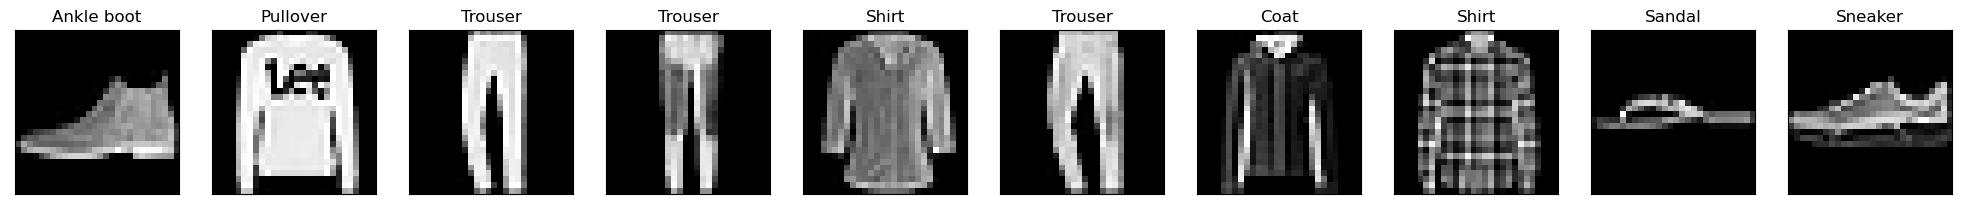

In [12]:
# visualize data
data_iter = iter(test_loader)
images, labels = next(data_iter)

# show fig
fig = plt.figure(figsize=(25, 10))
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for idx in np.arange(10):
    ax = fig.add_subplot(1, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx].item()])


In [8]:
import torch.nn as nn
import torch.nn.functional as F
class Model(nn.Module):
  
  def __init__(self):
    super(Model, self).__init__()
    
    #cnn
    self.conv1 = nn.Conv2d(1, 10, kernel_size=1)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=2)
    #self.conv3 = nn.Conv2d(20, 30, kernel_size=2)
    
    # pooling
    self.pool = nn.MaxPool2d(2, padding=1)
    
    #linear
    # linear layer (784 -> hidden_1)
    self.fc1 = nn.Linear(1280, 512)
    # linear layer (n_hidden -> hidden_2)
    self.fc2 = nn.Linear(512, 512)
    #self.fc3 = nn.Linear(512, 256)
    #self.fc4 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(512, 10)
    # dropout layer (p=0.2)
    # dropout prevents overfitting of data
    self.dropout = nn.Dropout(0.2)
    
    
  def forward(self,x):
    #cnn
    input_num = x.size(0)
    x = self.conv1(x)
    x = self.pool(x)
    x = F.relu(x)
    
    #cnn 2 and 3
    x = F.relu(self.pool(self.conv2(x)))
    #x = F.relu(self.pool(self.conv3(x)))
    
    #flaten the tensor
    x = x.view(input_num, -1)
    x = F.relu(self.fc1(x))
    # add dropout layer
    x = self.dropout(x)
    # add hidden layer, with relu activation function
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    
    #x = F.relu(self.fc3(x))
    #x = self.dropout(x)
    
    #x = F.relu(self.fc4(x))
    # add dropout layer
    #x = self.dropout(x)
    # add output layer
    x = self.fc3(x)
    return x
    

In [9]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (conv1): Conv2d(1, 10, kernel_size=(1, 1), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1280, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [10]:
n_epochs = 15

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() #*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(16):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
        
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    
    #clculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    print('\t\tTest Accuracy: %4d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.026156 	Validation Loss: 0.019473
		Test Accuracy:   57% (1432/2512)
Validation loss decreased (inf --> 0.019473).  Saving model ...
Epoch: 2 	Training Loss: 0.011188 	Validation Loss: 0.010865
		Test Accuracy:   64% (3249/5024)
Validation loss decreased (0.019473 --> 0.010865).  Saving model ...
Epoch: 3 	Training Loss: 0.008246 	Validation Loss: 0.009490
		Test Accuracy:   68% (5161/7536)
Validation loss decreased (0.010865 --> 0.009490).  Saving model ...
Epoch: 4 	Training Loss: 0.007279 	Validation Loss: 0.008413
		Test Accuracy:   71% (7138/10048)
Validation loss decreased (0.009490 --> 0.008413).  Saving model ...
Epoch: 5 	Training Loss: 0.006636 	Validation Loss: 0.007821
		Test Accuracy:   72% (9144/12560)
Validation loss decreased (0.008413 --> 0.007821).  Saving model ...
Epoch: 6 	Training Loss: 0.006200 	Validation Loss: 0.007406
		Test Accuracy:   74% (11181/15072)
Validation loss decreased (0.007821 --> 0.007406).  Saving model ...
Epoch: 7 	T

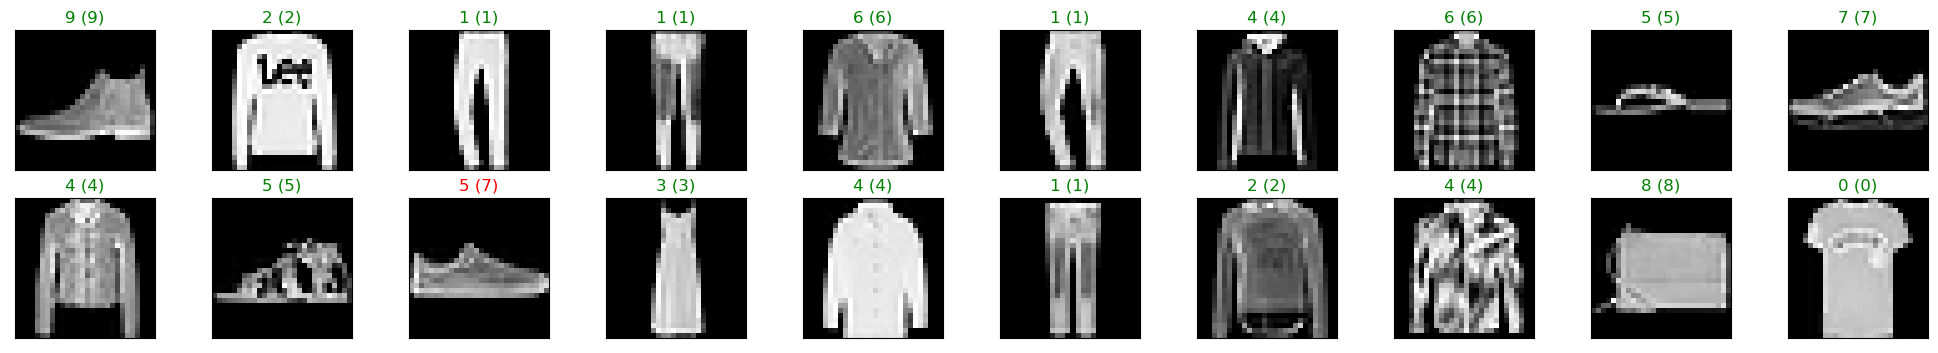

In [16]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move to cpu
model.cpu()

# get sample outputs
output = model(images)

# convert output probabilities to predicted class
_, preds = torch.max(output, 1)

# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(
        "{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
        color=("green" if preds[idx] == labels[idx] else "red")
    )


In [17]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # Move input and label tensors to the default device
    data, target = data.to(device), target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(16):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.382919

Test Accuracy of     0: 83% (209/250)
Test Accuracy of     1: 96% (254/262)
Test Accuracy of     2: 76% (198/258)
Test Accuracy of     3: 84% (226/266)
Test Accuracy of     4: 84% (216/255)
Test Accuracy of     5: 94% (232/245)
Test Accuracy of     6: 51% (133/259)
Test Accuracy of     7: 92% (226/245)
Test Accuracy of     8: 97% (225/230)
Test Accuracy of     9: 95% (232/242)

Test Accuracy (Overall): 85% (2151/2512)
